In [1]:
import pandas
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import regex

%matplotlib inline

In [2]:
part_df = pandas.read_table('data/partition.tsv.gz')
part_df = part_df.query('indication == 1 or percentile <= 0.02')

In [3]:
dwpc_df = pandas.read_table('data/dwpc-subset.tsv')
dwpc_df.head()

,compound_id,disease_id,metapath,path_count,w,dwpc
0,DB00014,DOID:10283,CsCiD,1,0.00,1.000000
1,DB00014,DOID:10283,CsCiD,1,0.02,0.865122
2,DB00014,DOID:10283,CsCiD,1,0.04,0.748436
3,DB00014,DOID:10283,CsCiD,1,0.06,0.647489
4,DB00014,DOID:10283,CsCiD,1,0.08,0.560157


In [4]:
def compute_metrics(df):
    y_true = df.indication
    y_score = df.dwpc
    series = pandas.Series()
    series['nonzero'] = (y_score > 0).mean()
    series['auroc'] = sklearn.metrics.roc_auc_score(y_true, y_score)
    series['auprc'] = sklearn.metrics.average_precision_score(y_true, y_score)
    return series

merged_df = part_df.merge(dwpc_df)
auc_df = merged_df.groupby(['metapath', 'w']).apply(compute_metrics).reset_index()

In [5]:
part_df.merge(dwpc_df).drop_duplicates(['compound_id', 'disease_id']).indication.value_counts()

0    44
1    13
dtype: int64

In [6]:
auc_df.groupby('metapath').var().auroc.max()

0.0038461993922709659

In [7]:
auc_df.head()

,metapath,w,nonzero,auroc,auprc
0,CbG<kdGaD,0.00,0.107143,0.533095,0.296932
1,CbG<kdGaD,0.02,0.107143,0.533989,0.303342
2,CbG<kdGaD,0.04,0.107143,0.533989,0.303342
3,CbG<kdGaD,0.06,0.107143,0.533989,0.303342
4,CbG<kdGaD,0.08,0.107143,0.533989,0.303342


In [8]:
auc_wide_df = auc_df.pivot_table('auroc', 'metapath', 'w')

## AUROC by feature and DWPC weight

In [9]:
#matplotlib.pyplot.figure(figsize=(7,35))
#ax = seaborn.heatmap(auc_wide_df)

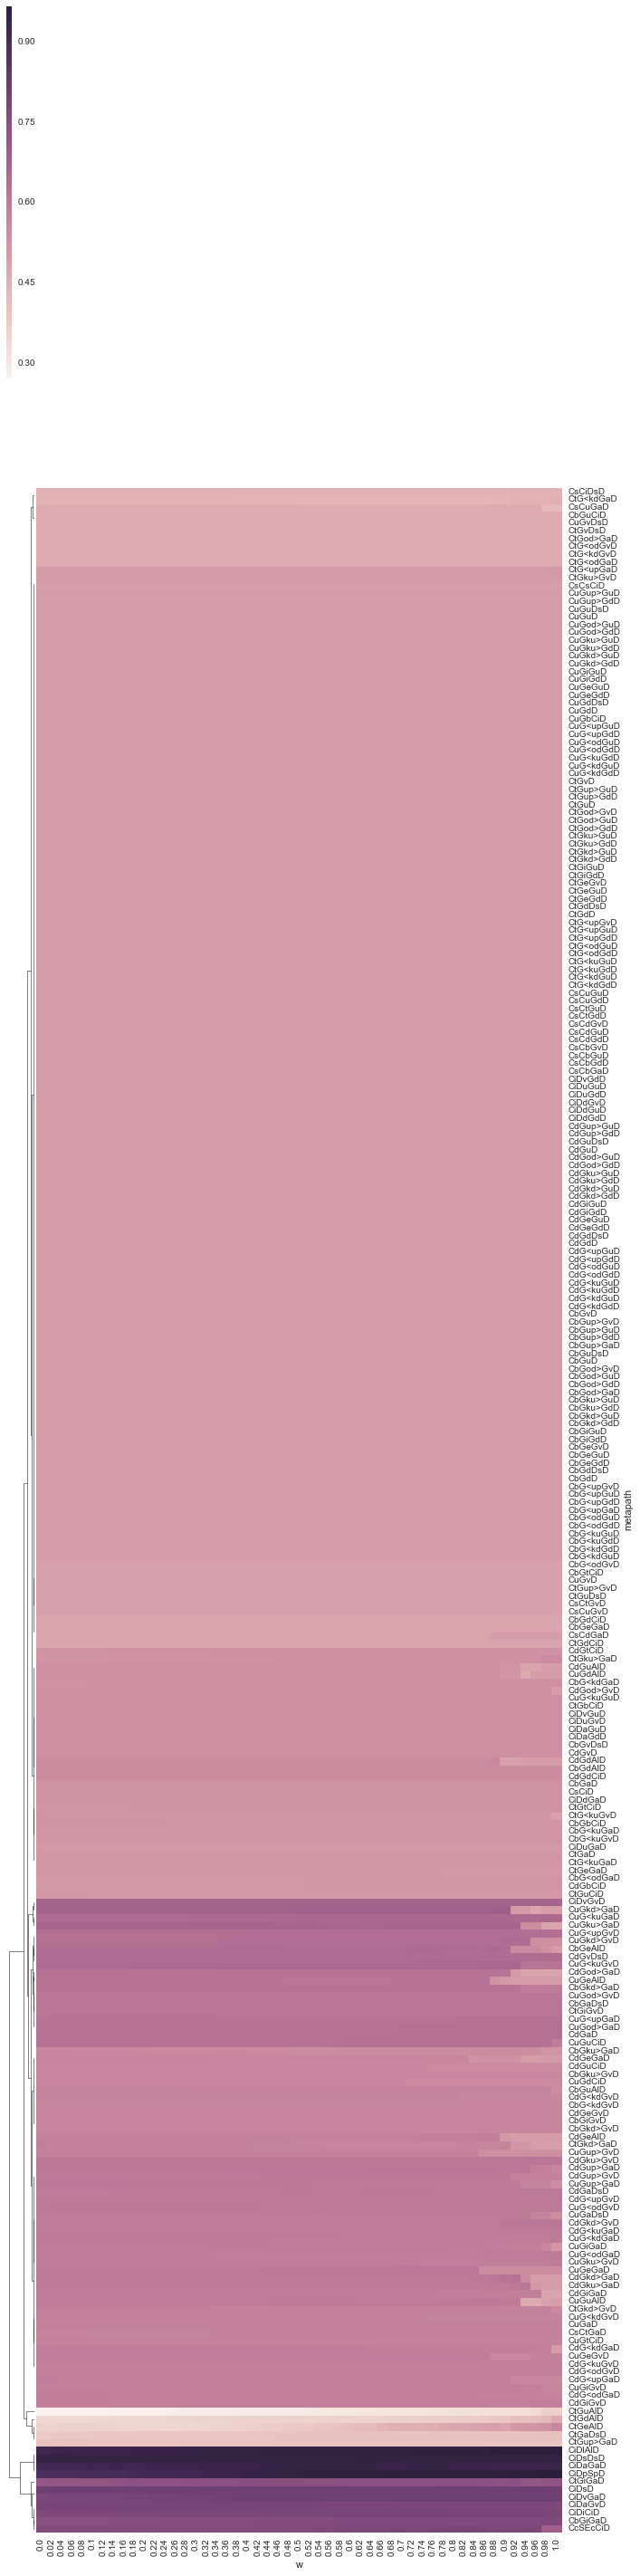

In [10]:
# https://github.com/mwaskom/seaborn/issues/471
clustergrid = seaborn.clustermap(auc_wide_df, col_cluster=False, figsize=(11, 50), )

## Metaedge AUROCS

In [11]:
def metaedges_from_metapath(abbreviation, arrange=False):
    """Get the abbreviated metaedges for an abbreviated metapath."""
    metaedges = regex.findall('(?<=^|[a-z<])[A-Z]+[a-z<>]+[A-Z]+', abbreviation, overlapped=True)
    if arrange:
        metaedges = [arrange_metaege(metaedge) for metaedge in metaedges]
    return metaedges

def arrange_metaege(abbreviation):
    if '>' in abbreviation:
        return abbreviation
    source, target = regex.split('[a-z<>]+', abbreviation)
    edge = regex.search('[a-z]+', abbreviation).group()
    if '<' in abbreviation:
        return '{}{}>{}'.format(target, edge, source)
    if source > target:
        return '{}{}{}'.format(target, edge, source)
    return abbreviation

In [13]:
auc04_df = auc_df.query('w == 0.4')

rows = list()
for metapath in auc04_df.metapath.unique():
    metaedges = metaedges_from_metapath(metapath, True)
    for metaedge in sorted(set(metaedges)):
        rows.append((metapath, metaedge))
metaedge_df = pandas.DataFrame(rows, columns=['metapath', 'metaedge'])

auc04_metaedge_df = metaedge_df.merge(auc04_df)
auc04_metaedge_df.head()

,metapath,metaedge,w,nonzero,auroc,auprc
0,CbG<kdGaD,CbG,0.4,0.107143,0.537567,0.393086
1,CbG<kdGaD,DaG,0.4,0.107143,0.537567,0.393086
2,CbG<kdGaD,Gkd>G,0.4,0.107143,0.537567,0.393086
3,CbG<kdGdD,CbG,0.4,0.000000,0.500000,0.616071
4,CbG<kdGdD,DdG,0.4,0.000000,0.500000,0.616071


In [14]:
order = auc04_metaedge_df.groupby('metaedge').auroc.max()
order.sort()
order = order.index

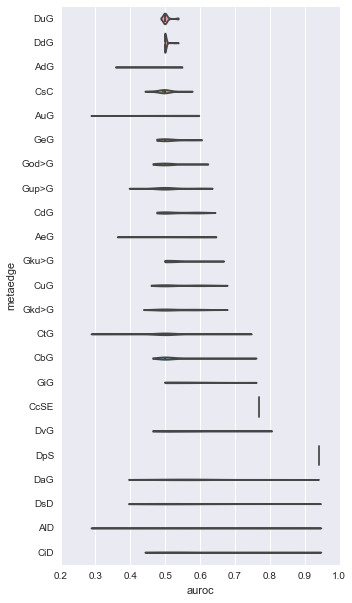

In [15]:
matplotlib.pyplot.figure(figsize=(5,10))
ax = seaborn.violinplot(x='auroc', y='metaedge', data=auc04_metaedge_df, orient='h', cut=0, inner='quartile', order=order)

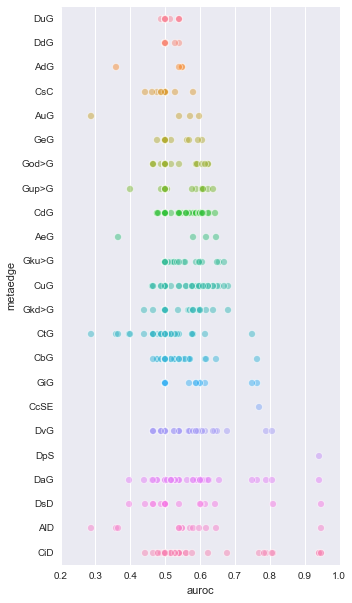

In [16]:
matplotlib.pyplot.figure(figsize=(5,10))
ax = seaborn.stripplot(x='auroc', y='metaedge', data=auc04_metaedge_df, orient='h', alpha = 0.5, order=order)